# Variational AutoEncoder

In this assignment, we will use the code from the Chollet textbook to build our own VAE model.

Some additional nodes

* We will use the MNIST data set in this excersize. If you want, you could also use the LFW deepfunneled data.
* The sample code uses tensorflow as the backend. You could also try to use torch as the backend.
* The sample code uses Keras3. If you are using Keras2, you probably need to user keras.backend instead of keras.ops.

## Setup

In [8]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

## Create a sampling layer

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(8237)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [10]:
latent_dim = 2
# The MNIST is 28x28x1
image_size = 28

encoder_inputs = keras.Input(shape=(image_size, image_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)

# Add another convolution layer with 64 channels, kernel size 3, relu activation, and stride size 2.
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)

# Flatten the output.
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Get the mean and variance and sample
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

## Build the decoder

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
# Upsample
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)

# Add another convolution transpose layer with 32 channels.
# Conv2DTranspose does upsampling
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

# Upsample
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

## Define the VAE as a `Model` with a custom `train_step`

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) # Mean of latent variable z, gets modeled as gaussian; z_log_var is log of the variance useful for numeric stability
            reconstruction = self.decoder(z)

            # Simple example for KL Loss:
            # [[0.1, 0.2],
            #  [0.3, 0.4],
            #  [0.5, 0.6]]
            # When you reduce the sum you'll get [0.1+0.2, 0.3+0.4, 0.5+0.6] = [0.3, 0.7, 1.1]
            # When you reduce the average you'll get (0.3+0.7+1.1)/3 = 0.7
            # Then there's a multiply by -0.5 which becomes the loss value = -0.35

            # Implement the reconstruction loss and KL divergence.
            #reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction)) # MSE version
            beta = 3.0 # new hyperparameter
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction)) # average binary cross entropy over the batch, would need to modify the decoder to match target/output shapes since BCE wants the same shape
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1)) # reduce sum should sum the values across latent dimensions and create a 1D tensor, then average over the batch

            total_loss = reconstruction_loss + beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

## Train the VAE

In [13]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=50, batch_size=128)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 106s 187ms/step - kl_loss: 7.7315e-05 - loss: 0.3429 - reconstruction_loss: 0.3427
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 139s 182ms/step - kl_loss: 4.3526e-11 - loss: 0.2629 - reconstruction_loss: 0.2629
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 144s 185ms/step - kl_loss: 1.1488e-10 - loss: 0.2626 - reconstruction_loss: 0.2626
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 139s 180ms/step - kl_loss: 8.3506e-11 - loss: 0.2626 - reconstruction_loss: 0.2626
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 100s 183ms/step - kl_loss: 1.1661e-10 - loss: 0.2628 - reconstruction_loss: 0.2628
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 142s 183ms/step - kl_loss: 2.6533e-09 - loss: 0.2629 - reconstruction_loss: 0.2629
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 145s 188ms/step - kl_loss: 2.2936e-09 - loss: 0.2629 - reconstruction_loss: 0.2629
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 142s 188ms/step - kl_loss: 2.2077e-09 - loss: 0.

## Display a grid of sampled digits

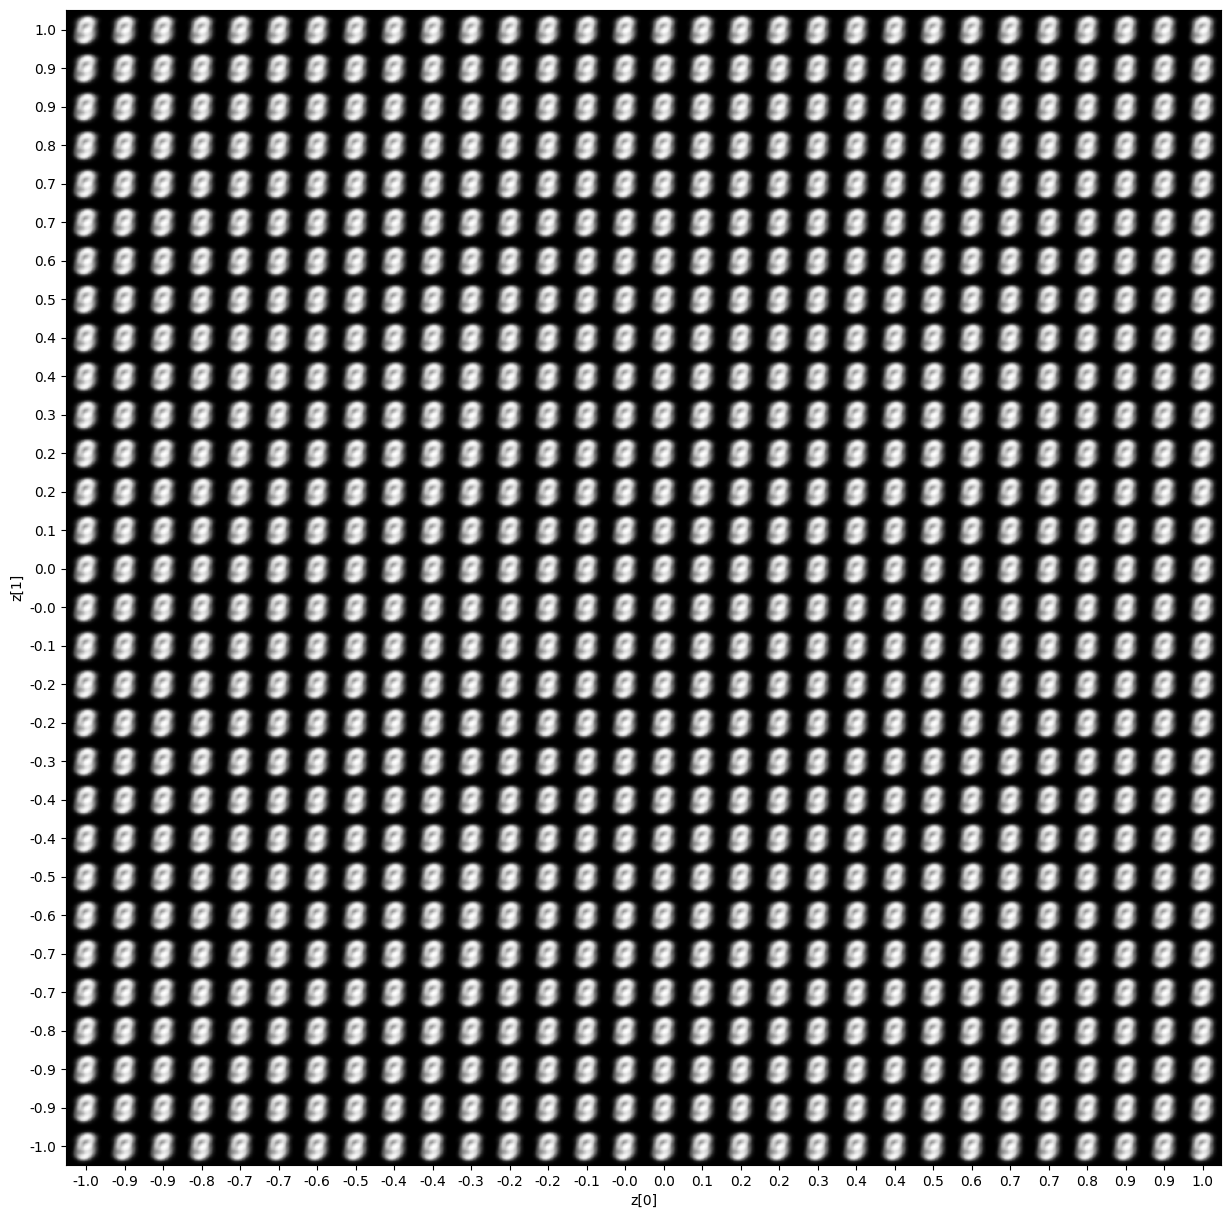

In [14]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters different digit classes

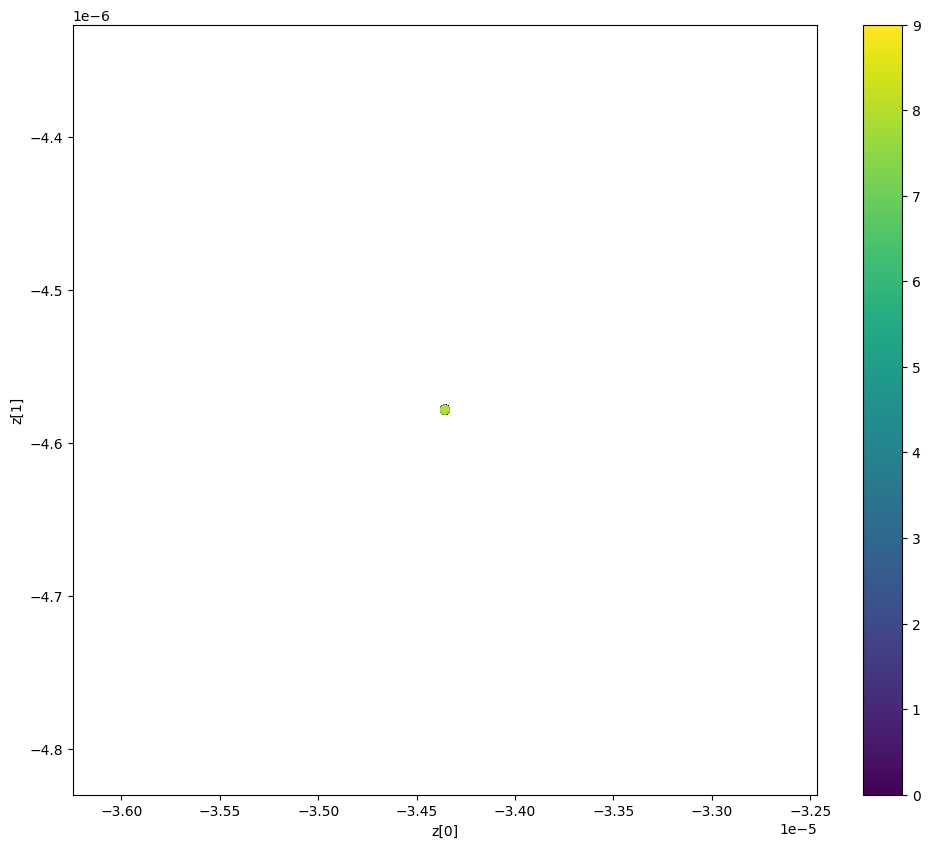

In [15]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

## Questions

* Examine the results. What does the x-dimention and y-dimention of the latency space represent?

# Answer
This whole graph is supposed to project the latent representation of the input images into two dimensions. The x-dim (z[0]) represents a learned feature or property of the image while the y-dim (z[1]) represents another learned feature that's probably complimenting the first one. Could be thickness, curvature, position, orientation, size, etc.

## Bonus

Try to adjust the layouts and see whether you see improvements.

### Bonus Tried:

* Beta Values (B-VAE) for a hyperparameter on the total loss
* Increasing epochs
* MSE vs BCE vs other loss functions
* Changing latent dimensions (not a good idea unless you want to change the plotting methodology)
* Modifying the plot itself (no improvement)
* I Tried to use Softplus as well.

# Model Analysis

Here we built a VAE where we build our encoder sequentially, flatten, and then bottleneck down to our latent space of 1-dimension. The latent space is decoded and then upsampled 3 times to fit.

The results are a bit confusing because the clustering is really tough to see, so some improvements to clustering were done as part of the Bonus. This included trying out Beta values (new hyperparameter!) to make a B-VAE and some other methods like increasing epochs. I tried increasing the latent dimensions but hit a wall there with the plotting methodology and I am just not good at that aspect so didn't want to rewrite it.

I also tried using different reconstruction loss methods (MSE vs. BCE).

I didn't run into any problems with my VAE other than the latent space representation of digit classes being a small cluster and not well-separated. With only 2 dimensions in the latent space I guess that's a byproduct?

In [40]:
%%shell

jupyter nbconvert --to html /content/vae_BradleyBullman.ipynb